# Problem Set 2

In [174]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import math
import scipy.special as sp
import scipy.integrate as integ

claims = np.loadtxt('clms.txt')

# (a) First histogram with 1000 bins

<IPython.core.display.Javascript object>


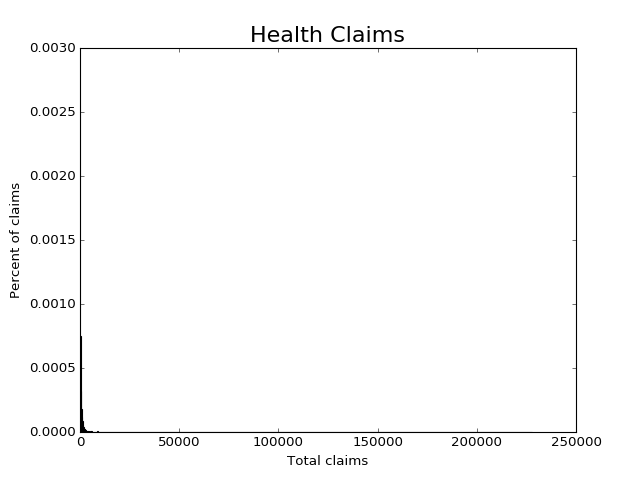

Average= 720.277975327 
Median= 172.21 
Variance= 15782057.3214


In [176]:
# This next command is specifically for Jupyter Notebook
%matplotlib notebook

plt.hist(claims, 1000, normed=True)
plt.title('Health Claims', fontsize=20)
plt.xlabel('Total claims')
plt.ylabel('Percent of claims')
#plt.xlim([0, 550])  # This gives the xmin and xmax to be plotted"

print('Average=', np.mean(claims),
     '\nMedian=', np.median(claims),
     '\nVariance=',np.var(claims))


Median is much lower than the average, which implies a long right tail. This is consistent with the histogram we plot, although we cannot see much part from the histogram. 

# (b) Second histogram with 100 bins and data points that have values less than 800


<IPython.core.display.Javascript object>


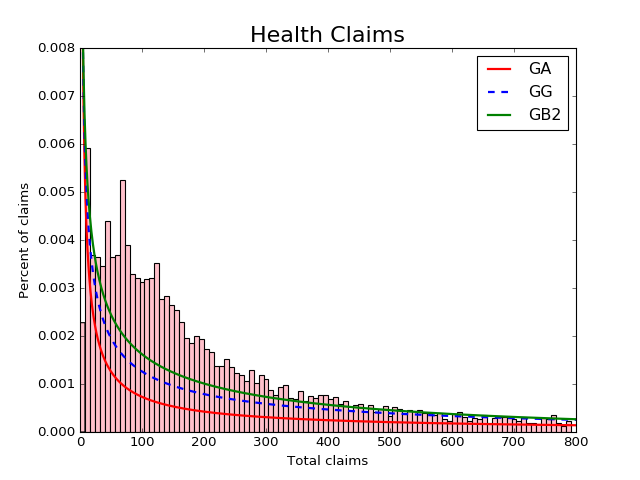

In [177]:
binBoundaries = np.arange(0,800,8)
#print(binBoundaries[:10])
%matplotlib notebook 

plt.hist(claims, bins=binBoundaries, range=(0,800), normed=True, color='pink')
plt.xlim([0, 800])  # This gives the xmin and xmax to be plotted"
plt.ylim([0, 0.008])
plt.title('Health Claims', fontsize=20)
plt.xlabel('Total claims')
plt.ylabel('Percent of claims')

The second histogram shows a lot more information about the shape of the data distribution. The first histogram (including all data points) seems very uninformative except that it shows the existence of a very long and thin right tail. 

# (b) Fit GA distribution with 2 parameters

In [178]:
# Define function that generates values of a normal pdf
def GA_pdf(x, aa, bb):

    pdf_vals = sts.gamma.pdf(x,aa, loc=0, scale=bb)
            
    return pdf_vals

In [179]:
## Log likelihood function
def log_lik(params, *args):
    x, dist = args
    if dist == 'GA':
        aa, bb = params
        pdf_vals = GA_pdf(x, aa,bb)
    if dist == 'GG':
        aa,bb,mm = params
        pdf_vals = GG_pdf(x,aa,bb,mm)
    if dist == 'GB2':
        aa,bb,pp,qq = params
        pdf_vals = GB2_pdf(x,(aa,bb,pp,qq))

    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

In [180]:
import scipy.optimize as opt

b_init = np.var(claims)/np.mean(claims)  
a_init = np.mean(claims)/b_init  
params_init = np.array([a_init, b_init])

bnds = ((0, None), (0, None))
ga_args = (claims, 'GA')
resultsGA = opt.minimize(log_lik, params_init, args=ga_args, bounds = bnds, method='L-BFGS-B')
a_GA_MLE, b_GA_MLE = resultsGA.x
print('a_GA_MLE=', a_GA_MLE, 'b_GA_MLE=', b_GA_MLE, 'Log Likelihood=', -resultsGA.fun)

a_GA_MLE= 0.221755308612 b_GA_MLE= 21911.0646993 Log Likelihood= -82076.4516057


In [181]:
pts = np.linspace(0, 800, 1000)

plt.plot(pts,GA_pdf(pts, a_GA_MLE, b_GA_MLE),
         linewidth=2, color='r', label='GA')
plt.legend(loc='upper right')

# (c) Fit GG distribution with 3 parameters 

In [182]:
def GG_pdf(x, aa, bb, mm):
    pdf_vals = sts.gengamma.pdf(x,aa, mm, scale=bb)
            
    return pdf_vals

In [183]:
b_init = b_GA_MLE - 20000
a_init = a_GA_MLE - 0.2
m_init = 1
params_init = np.array([a_init, b_init, m_init])

bnds = ((1e-20, None), (1e-20, None), (1e-20,None))
gg_args = (claims, 'GG')
resultsGG = opt.minimize(log_lik, params_init, args=gg_args, bounds = bnds,method='L-BFGS-B')
a_GG_MLE, b_GG_MLE, m_GG_MLE = resultsGG.x
print('a_GG_MLE=', a_GG_MLE, '\nb_GG_MLE=', b_GG_MLE, '\nm_GG_MLE=', m_GG_MLE, '\nLog Likelihood=', -resultsGG.fun)

a_GG_MLE= 0.502584072759 
b_GG_MLE= 1911.06433197 
m_GG_MLE= 0.836551528409 
Log Likelihood= -77564.2587079


In [184]:
plt.plot(pts,GG_pdf(pts, a_GG_MLE, b_GG_MLE, m_GG_MLE),
         linewidth=2, color='b', ls='dashed', label='GG')
plt.legend(loc='upper right')

# (d) Fit GB2 distribution

In [185]:
def GB2_pdf(x, params):
    aa,bb,pp,qq = params
    pdf_vals = (np.abs(aa)*(x**(aa*pp -1)))/((bb**(aa*pp))*sp.beta(pp,qq)*((1+((x/bb)**aa))**(pp+qq)))
            
    return pdf_vals

In [186]:

a_init = m_GG_MLE 
p_init = a_GG_MLE
q_init = 10000
b_init = (q_init**(1/m_GG_MLE))*b_GG_MLE -3
params_init = np.array([a_init, b_init, p_init, q_init])

bnds = ((1e-10, None), (1e-10, None), (1e-10,None), (1e-10, None))
gb2_args = (claims, 'GB2')
resultsGB = opt.minimize(log_lik, params_init, args=gb2_args, bounds = bnds, method='TNC')
a_GB2_MLE, b_GB2_MLE, p_GB2_MLE, q_GB2_MLE = resultsGB.x
print('a_GB2_MLE=', a_GB2_MLE, '\nb_GB2_MLE=', b_GB2_MLE, '\np_GB2_MLE=', p_GB2_MLE, '\nq_GB2_MLE=', q_GB2_MLE,
     '\n Log Likelihood=', -resultsGB.fun)

resultsGB

print(b_init)

a_GB2_MLE= 0.771703144993 
b_GB2_MLE= 115560603.885 
p_GB2_MLE= 0.688283963704 
q_GB2_MLE= 9991.70956029 
 Log Likelihood= -76792.4433481
115560603.885


In [187]:
plt.plot(pts,GB2_pdf(pts, (a_GB2_MLE, b_GB2_MLE, p_GB2_MLE, q_GB2_MLE)),
         linewidth=2, color='g', label='GB2')
plt.legend(loc='upper right')

C:\Users\Sophie\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in power
  app.launch_new_instance()


I find that the starting values matter a lot not only in terms of log likelihoods but also in terms of convergence. Even adding a small number to a big initial value (e.g., adding a small number to $\beta_0> 115,500,000$ makes the model fail to converge). 

We saw in class that the results also depend on which optimizer we use. The bigger questions might include: 1) Is the model we use the right moel? 2) Do we use the right data to answer the question of interest? 3) Does the model achieve global optimum? (which is related to the initial value problems). 

# (e) Log likelihood ratio test

The LR statistic is
$$LR(\hat{\theta_c}|\hat{\theta}) = 2(ln(\mathcal{L}(\hat{\theta}))- ln(\mathcal{L}(\hat{\theta_c}) $$
where $\hat{\theta_c}$ is a set of estimated parameters under constraints and $\hat{\theta}$ is a set of unconstrained parametres. 

In [188]:
test_GA = 2*((-resultsGB.fun)-(-resultsGA.fun))
test_GG = 2*((-resultsGB.fun)-(-resultsGG.fun))

print('LR statistic for GA vs. GB2 = ',test_GA)
print('p-value', 1-sts.chi2.cdf(test_GA,4))
print('LR statistic for GG vs. GB2 = ',test_GG)
print('p-value',1-sts.chi2.cdf(test_GG,4))

LR statistic for GA vs. GB2 =  10568.0165151
p-value 0.0
LR statistic for GG vs. GB2 =  1543.63071955
p-value 0.0


As the test statistics show, $\theta_{GB2}$ are statistically different both from $\theta_{GA}$ and from $\theta_{GG}$.

# (f) How likely am I to have a monthly health care claim of more than $1,000?

In [189]:
print('GA case: ', 1 - sts.gamma.cdf(1000, a_GA_MLE, loc=0, scale = b_GA_MLE))
print('GB2 case: ', 1 - integ.quad(GB2_pdf, a=0, b=1000, args=(resultsGB.x))[0])

claims_trunc = 1*(claims>1000)
print('Data: ', np.mean(claims_trunc))

GA case:  0.451959722389
GB2 case:  0.17669457906161767
Data:  0.122610415293


As we can see from the computed probabilities, GB2 distribution captures the right tail more accurately. According to the plot, the model with GG distribution assigns less probability to the lower values and more probability to the right tail than the model with GB2 distribution does, which is consistent with the overestimated probability reported above.  